# Dimensionality reduction techniques comparison

### Dataset



These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of 13 constituents found in each of the three types of wines.

I think that the initial data set had around 30 variables, but for some reason I only have the 13 dimensional version. I had a list of what the 30 or so variables were, but a.)  I lost it, and b.), I would not know which 13 variables are included in the set.

For simplicity we use the Wine dataset from sklearn (UCI).

Features:
- alcohol
- malic_acid
- ash
- alcalinity_of_ash
- magnesium
- total_phenols
- flavanoids
- nonflavanoid_phenols
- proanthocyanins
- color_intensity
- hue
- od280od315_of_diluted_wines'
- proline

Labels: Wine classes

In [1]:
from sklearn.datasets import load_wine
import numpy as np

data = load_wine()
features = data["data"]
labels = data["target"]
features.shape

(178, 13)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
try:
  import ipyvolume as ipv
except:
  %pip install ipyvolume -q
  import ipyvolume as ipv
  !jupyter nbextension enable --py --sys-prefix ipyvolume

def visualize_2d(x, labels):
    sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=labels, s=100, alpha=0.8,
                    palette="Greens", edgecolor="black")

def visualize_3d(x, labels):
    # Workaround as axis limits are not auto-scaling
    x_norm = (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))
    fig = ipv.figure(height=400, width=400)
    x, y, z = x_norm[:, 0], x_norm[:, 1], x_norm[:, 2]

    # Colors
    cmap = plt.get_cmap('Greens', 3)
    color = cmap(labels)
    ipv.scatter(x, y, z, size=4, marker="sphere", color=color)
    ipv.show()

### PCA

In [3]:
# It's also possible to manually compute eigenvectors and eigenvalues
subset_idx = 3
cov = np.cov(features)[:subset_idx, :subset_idx]
eig_vals, eig_vecs = np.linalg.eig(cov)
print("Eigenvalues: \n", eig_vals)
print("Eigenvectors: \n", eig_vecs)

Eigenvalues: 
 [2.75887696e+05 5.66833522e+01 1.34732230e+00]
Eigenvectors: 
 [[-0.55810925 -0.78959847  0.25504573]
 [-0.55046096  0.12232505 -0.82585066]
 [-0.62089193  0.60130761  0.50291387]]


2D Projection

CPU times: total: 0 ns
Wall time: 997 µs


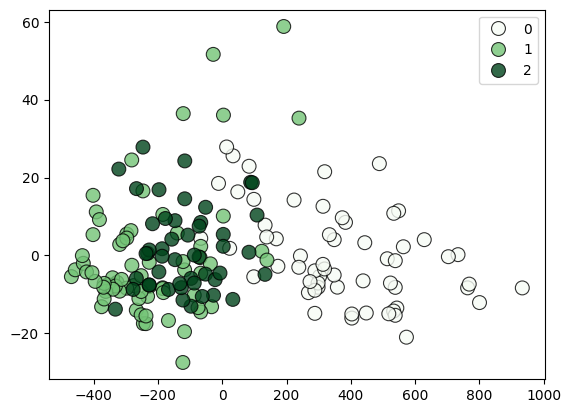

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
%time pca_2d = pca.fit_transform(features)
visualize_2d(x=pca_2d, labels=labels)

In [5]:
print("Eigenvalues: \n", pca.explained_variance_ratio_)
print("Eigenvectors: \n", pca.components_)


Eigenvalues: 
 [0.99809123 0.00173592]
Eigenvectors: 
 [[ 1.65926472e-03 -6.81015556e-04  1.94905742e-04 -4.67130058e-03
   1.78680075e-02  9.89829680e-04  1.56728830e-03 -1.23086662e-04
   6.00607792e-04  2.32714319e-03  1.71380037e-04  7.04931645e-04
   9.99822937e-01]
 [ 1.20340617e-03  2.15498184e-03  4.59369254e-03  2.64503930e-02
   9.99344186e-01  8.77962152e-04 -5.18507284e-05 -1.35447892e-03
   5.00440040e-03  1.51003530e-02 -7.62673115e-04 -3.49536431e-03
  -1.77738095e-02]]


3D Projection

In [6]:
pca = PCA(n_components=3)
%time pca_3d = pca.fit_transform(features)
visualize_3d(pca_3d, labels)

CPU times: total: 0 ns
Wall time: 0 ns


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

### MDS

In [7]:
# Precompute distance
from sklearn.metrics.pairwise import manhattan_distances

d_matrix = manhattan_distances(features)
d_matrix

array([[  0.  ,  51.06, 152.48, ..., 257.14, 249.41, 558.28],
       [ 51.06,   0.  , 148.3 , ..., 257.98, 250.55, 521.18],
       [152.48, 148.3 ,   0.  , ..., 384.76, 376.83, 649.14],
       ...,
       [257.14, 257.98, 384.76, ...,   0.  ,   8.15, 306.74],
       [249.41, 250.55, 376.83, ...,   8.15,   0.  , 312.09],
       [558.28, 521.18, 649.14, ..., 306.74, 312.09,   0.  ]])

Distance matrix of the first 10 data points...


<Axes: >

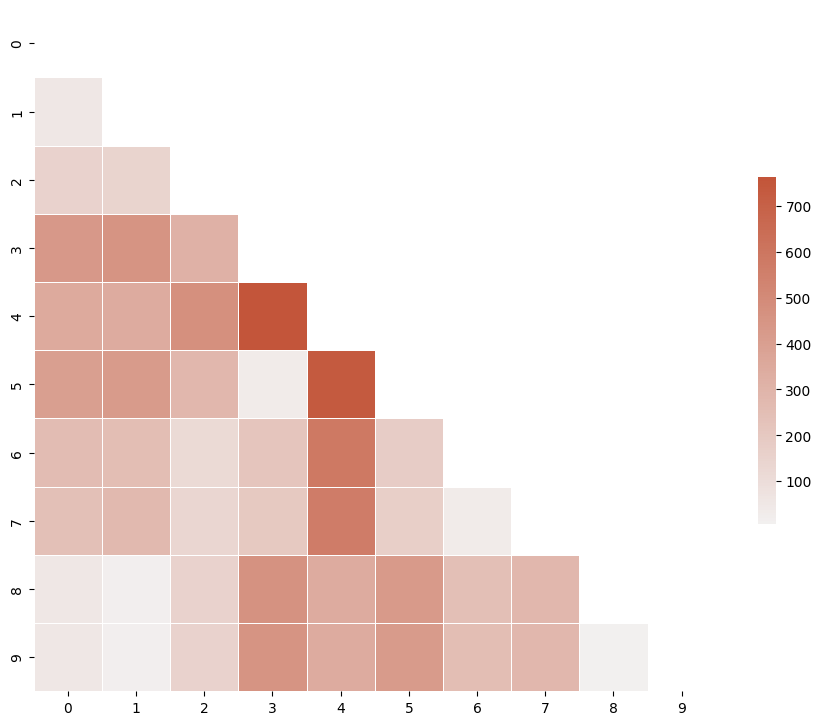

In [8]:
import seaborn as sns
print("Distance matrix of the first 10 data points...")
distances = d_matrix[:10, :10]

mask = np.triu(np.ones_like(distances, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(distances, mask=mask, cmap=cmap, vmax=distances.max(), center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [9]:
from sklearn.manifold import MDS

mds = MDS(n_components=3,
          normalized_stress=False,
          metric=True,
          dissimilarity="precomputed",
          random_state=2023,
          eps=1e-9)
%time mds_3d = mds.fit_transform(d_matrix)
visualize_3d(mds_3d, labels)

CPU times: total: 594 ms
Wall time: 548 ms


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

Note: It works better with Manhatten distances - most likely the high dimension is a problem using the euclidean distance

In [10]:
print("Raw stress: ", mds.stress_)

Raw stress:  882441.0641476295


CPU times: total: 875 ms
Wall time: 479 ms


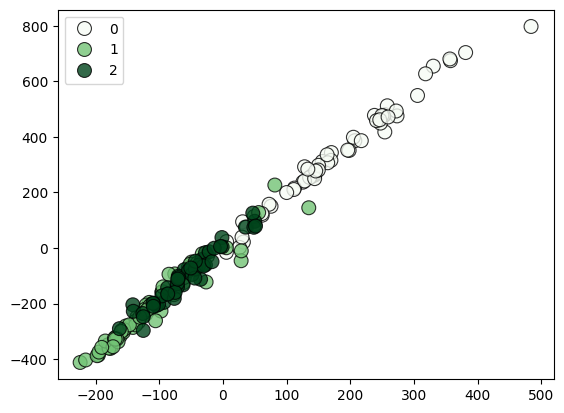

In [11]:
mds = MDS(n_components=2, normalized_stress=False, eps=1e-9)
%time mds_2d = mds.fit_transform(features)
visualize_2d(mds_2d, labels)

### TSNE

In [12]:
from sklearn.manifold import TSNE

%time tsne_3d = TSNE(n_components=3, perplexity=10, early_exaggeration=12, learning_rate='auto', init='pca', n_jobs=4).fit_transform(features)
visualize_3d(tsne_3d, labels)

CPU times: total: 1 s
Wall time: 538 ms


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

CPU times: total: 328 ms
Wall time: 293 ms


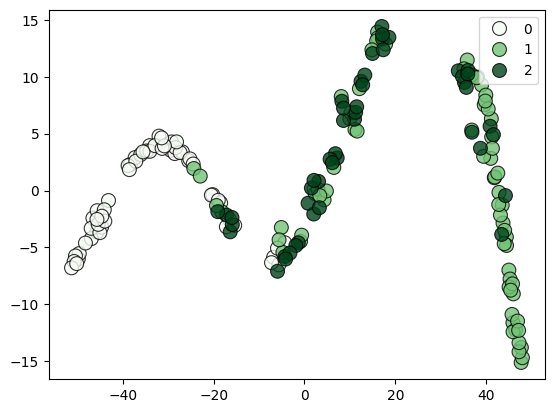

In [13]:
%time tsne_2d = TSNE(n_components=2, perplexity=10, early_exaggeration=12, learning_rate='auto', init='random', n_jobs=4).fit_transform(features)
visualize_2d(tsne_2d, labels)

### UMAP

In [14]:
try:
  import umap.umap_ as umap
except:
  !pip install umap-learn -q
  import umap.umap_ as umap


# n_neighbors=15, min_dist=0.1, n_components=2, metric='euclidean'

reducer = umap.UMAP(n_components=3)
%time umap_3d = reducer.fit_transform(features)
visualize_3d(umap_3d, labels)

CPU times: total: 4.94 s
Wall time: 6.84 s


Container(figure=Figure(box_center=[0.5, 0.5, 0.5], box_size=[1.0, 1.0, 1.0], camera=PerspectiveCamera(fov=45.…

CPU times: total: 1.3 s
Wall time: 2 s


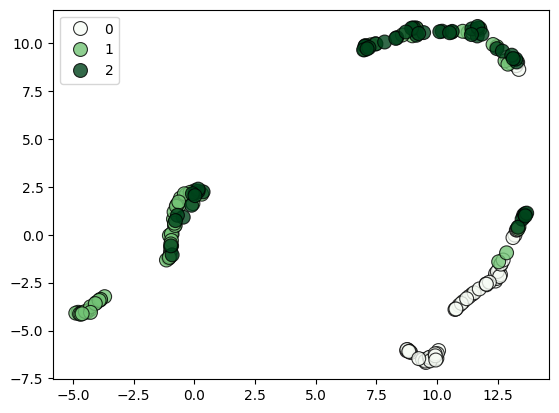

In [15]:
reducer = umap.UMAP(n_components=2)
%time umap_2d = reducer.fit_transform(features)
visualize_2d(umap_2d, labels)